In [1]:
import snappy
from snappy import ProductIO
import datetime
import sys
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from netCDF4 import Dataset
from scipy import signal
import cv2
import calibrate
import direction
import cmod5n
import horstmann
from PIL import Image
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [37]:
data = Dataset('./S1A_IW_GRDH_1SDV_20170518T141604_20170518T141629_016637_01B9B7_C40C.nc')
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
sigma_vv = data.variables['Sigma0_VV'][:]
sigma_vh = data.variables['Sigma0_VH'][:]
incident = data.variables['incident_angle'][:]

In [38]:
ndbc_dire = (190-318+90)%360
sub_lat = lat[9800:14210,15950:20360]
sub_lon = lon[9800:14210,15950:20360]
poly_lat = [sub_lat[0,0],sub_lat[0, -1],sub_lat[-1,-1],sub_lat[-1, 0],sub_lat[0,0]]
poly_lon =  [sub_lon[0,0],sub_lon[0, -1],sub_lon[-1,-1],sub_lon[-1, 0],sub_lon[0,0]]
sub_vv = sigma_vv[9800:14210,15950:20360]
sub_vh = sigma_vh[9800:14210,15950:20360]
sub_in = incident[9800:14210,15950:20360]
#风向
dire_ = direction.get_dir(sub_vv, sub_size=500, remove_ambi = True, ndbc_= ndbc_dire)

sub_size=500
sub_size_h = int(sub_size/2)
shape_x = sub_vv.shape[0]
shape_y = sub_vv.shape[1]
x_, y_ = np.arange(sub_size_h, shape_x-sub_size_h, sub_size), np.arange(sub_size_h, shape_y-sub_size_h, sub_size)
points = np.meshgrid(x_, y_)


image1 = Image.fromarray(sub_vv)
out1 = image1.transpose(Image.FLIP_LEFT_RIGHT)
out1 = out1.rotate(351, expand=1)
sub= np.array(out1)
#map对象
map_1 = Basemap(projection='stere',lat_0=np.max(sub_lat),lon_0=np.min(sub_lon),\
            llcrnrlat=np.min(sub_lat) ,urcrnrlat=np.max(sub_lat),\
            llcrnrlon=np.min(sub_lon),urcrnrlon=np.max(sub_lon), resolution='f')

X, Y = map_1(sub_lon[points], sub_lat[points])
index = 0
color_list = [(1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1)]



In [21]:
ndbc_speed = 6.6*np.power(10/5,0.11)
speed1 = []
for d in dire_:
    speed1.append(get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, d[points],c= 'cmod5n'))
ndbc_dire = (190-318+90)%360
ww1 = direction.Median_filter(w1=dire_[0][points], w2=dire_[1][points], b=ndbc_dire, filter_size=4)
speed11 = get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, ww1,c='cmod5n')

In [22]:
speed2 = []
for d in dire_:
    speed2.append(get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, d[points], c='horstmann'))
ndbc_dire = (190-318+90)%360
ww2 = direction.Median_filter(w1=dire_[0][points], w2=dire_[1][points], b=ndbc_dire, filter_size=4)
speed21 = get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, ww2,c='horstmann')

In [39]:
speed3 = []
for d in dire_:
    speed3.append(get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, d[points], c='combine'))
ww3 = direction.Median_filter(w1=dire_[0][points], w2=dire_[1][points], b=ndbc_dire, filter_size=4)
speed31 = get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, ww3,c='combine')

/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is d

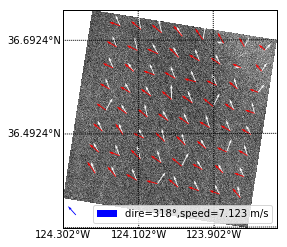

In [151]:
map_1.drawcoastlines()
map_1.imshow(-10*np.log10(sub),origin='upper',cmap='gray')
parallels=np.arange(np.min(sub_lat), np.max(sub_lat), 0.2)
map_1.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(sub_lon), np.max(sub_lon), 0.2)
map_1.drawmeridians(meridians,labels=[0,0,0,1])
map_1.drawmapboundary(fill_color='white')
index=0
for d, s in zip(dire_, speed1):
    U1 = 10*s*np.sin((280-d[points])%360/180*np.pi)
    V1 = 10*s*np.cos((280-d[points])%360/180*np.pi)
    map_1.quiver(X, Y, U1, V1, width=0.004, color=color_list[index])
    index+=1
map_1.quiver([[3000]], [3000], [[10*ndbc_speed*np.sin(318/180*np.pi)]], [[10*ndbc_speed*np.cos(318/180*np.pi)]], width=0.004, color=(0,0, 1), label='dire=318°,speed=%.3f m/s'%ndbc_speed)
plt.legend()
plt.savefig('./1_filed_5.png', dpi=400)

/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is d

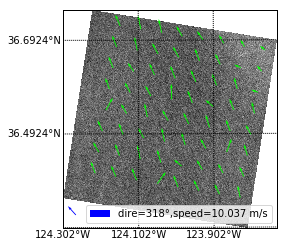

In [41]:
d = ww3
U1 = 10*speed31*np.sin((280-d)%360/180*np.pi)
V1 = 10*speed31*np.cos((280-d)%360/180*np.pi)

map_1.drawcoastlines()
map_1.imshow(-10*np.log10(sub),origin='upper',cmap='gray')
parallels=np.arange(np.min(sub_lat), np.max(sub_lat), 0.2)
map_1.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(sub_lon), np.max(sub_lon), 0.2)
map_1.drawmeridians(meridians,labels=[0,0,0,1])
map_1.drawmapboundary(fill_color='white')

map_1.quiver(X, Y, U1, V1, width=0.004, color=(0, 1, 0))
map_1.quiver([[3000]], [3000], [[10*ndbc_speed*np.sin(318/180*np.pi)]], [[10*ndbc_speed*np.cos(318/180*np.pi)]], width=0.004, color=(0,0, 1), label='dire=318°,speed=%.3f m/s'%ndbc_speed)
plt.legend()
plt.savefig('./1_filed_m_5.png', dpi=400)

In [3]:
def cmod5n_horstmann(v, vv, vh, phi, incident):
    return ((10*np.log10(vv)-10*np.log10(cmod5n.cmod5n_forward(v, phi, incident)))**2) + 0.17*(vh- horstmann.horstmann(v))**2

def minimize(vv, vh, phi, incident):
    v = np.zeros(len(vv))
    v1 = np.copy(v)
    mini = cmod5n_horstmann(v1, vv, vh, phi, incident)
    for i in np.arange(0, 22, 0.1):
        v1 += 0.1
        m = cmod5n_horstmann(v1,  vv, vh, phi, incident)
        v[mini>m] = v1[mini>m]
        mini[mini>m] = m[mini>m]
    return v

def get_speed(figure1,figure2,inci,sub_size,w_dir,c):
    sub_size_h = int(sub_size/2)
    shape_x = figure1.shape[0]
    shape_y = figure1.shape[1]
    s_vv = np.zeros((shape_x, shape_y))
    s_vh = np.zeros((shape_x, shape_y))
    incident_angle = np.zeros((shape_x, shape_y))
    p=np.zeros((shape_x, shape_y))
    #cut off head and tail
    for i in np.arange(sub_size_h, shape_x-sub_size_h,sub_size):
        for j in np.arange(sub_size_h, shape_y-sub_size_h, sub_size):
            img1 = figure1[i-sub_size_h:i+sub_size_h, j-sub_size_h:j+sub_size_h]
            img2 = figure2[i-sub_size_h:i+sub_size_h, j-sub_size_h:j+sub_size_h]
            inci1 = inci[i-sub_size_h:i+sub_size_h, j-sub_size_h:j+sub_size_h]
            s_vv[i,j] = np.mean(img1)
            s_vh[i,j] = np.mean(img2)
            p[i,j]=1
            incident_angle[i,j] = np.mean(inci1)
    s_vv = np.ravel(s_vv[points])
    s_vh = np.ravel(s_vh[points])
    incident_angle = np.ravel(incident_angle[points])
    w_dir = np.ravel(w_dir)
    if c=='cmod5n':
        v = cmod5n.cmod5n_inverse(incidence=incident_angle,phi=w_dir,sigma0_obs=s_vv)
    elif c=='horstmann':
        v = horstmann.inverse_horstmann(x=s_vh)
    elif c=='combine':
        v = minimize(s_vv, s_vh, w_dir, incident_angle)
    return np.reshape(v, (points[0].shape[0], points[1].shape[1]))

In [25]:
print(np.sqrt(np.sum(np.power(ndbc_speed-speed1[0],2))/len(np.ravel(speed1[0]))))
print(np.sqrt(np.sum(np.power(speed1[0]-np.mean(speed1[0]),2))/len(np.ravel(speed1[0]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed1[1],2))/len(np.ravel(speed1[1]))))
print(np.sqrt(np.sum(np.power(speed1[1]-np.mean(speed1[1]),2))/len(np.ravel(speed1[1]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed11,2))/len(np.ravel(speed11))))
print(np.sqrt(np.sum(np.power(speed11-np.mean(speed11),2))/len(np.ravel(speed11))))

5.20998441537
1.68223066534
1.9755051509
0.899326050933
4.90243123288
1.88621820796


In [26]:
print(np.sqrt(np.sum(np.power(ndbc_speed-speed2[0],2))/len(np.ravel(speed2[0]))))
print(np.sqrt(np.sum(np.power(speed2[0]-np.mean(speed2[0]),2))/len(np.ravel(speed2[0]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed2[1],2))/len(np.ravel(speed2[1]))))
print(np.sqrt(np.sum(np.power(speed2[1]-np.mean(speed2[1]),2))/len(np.ravel(speed2[1]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed21,2))/len(np.ravel(speed21))))
print(np.sqrt(np.sum(np.power(speed21-np.mean(speed21),2))/len(np.ravel(speed21))))

3.3036163467
1.44336149038
3.3036163467
1.44336149038
3.3036163467
1.44336149038


In [27]:
print(np.sqrt(np.sum(np.power(ndbc_speed-speed3[0],2))/len(np.ravel(speed3[0]))))
print(np.sqrt(np.sum(np.power(speed3[0]-np.mean(speed3[0]),2))/len(np.ravel(speed3[0]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed3[1],2))/len(np.ravel(speed3[1]))))
print(np.sqrt(np.sum(np.power(speed3[1]-np.mean(speed3[1]),2))/len(np.ravel(speed3[1]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed31,2))/len(np.ravel(speed31))))
print(np.sqrt(np.sum(np.power(speed31-np.mean(speed31),2))/len(np.ravel(speed31))))

4.96608263851
1.52202578822
2.00541329791
0.840363574591
4.67363048129
1.70754229335


In [102]:
print(speed1)

[[  6.5   7.2   6.9  11.4  10.4  11.3  10.5  12. ]
 [  7.8   7.1  11.4  11.4  11.5  13.8  10.2  10.8]
 [  9.2  11.1  12.    9.5  12.7  10.8  10.8  11.4]
 [ 10.3  12.6  12.5  12.9  12.   12.7   9.7  12.3]
 [ 11.4  11.9  13.   15.1  11.5  13.3  12.9  13.9]
 [ 13.6  11.8  12.2  11.4  13.3  11.2  13.7  12.5]
 [ 13.6  13.2  10.3  11.   10.7  11.7  12.   11.6]
 [ 11.8  11.8  11.8  11.4  13.6  11.4  11.   12. ]]


In [101]:
print(speed[1])

[[  6.5   7.2   6.9   7.6   8.3   8.    7.8   9.1]
 [  7.8   7.1   8.4   8.5   8.4   8.1   8.9   8.1]
 [  9.2   8.7   8.6   9.5   8.9   9.1   8.7   8.5]
 [ 10.3   9.2   9.1   9.7   9.5   9.7   9.7   9.5]
 [ 10.5  10.3   9.5   9.9   9.3   9.7   9.3   8.7]
 [  9.7   9.2   8.9   9.3   9.4   8.9  10.1   9.3]
 [  9.6   8.8   9.2   8.8   8.9  10.2   8.5  10. ]
 [  8.6   8.7   8.5   8.4   8.7   9.1   9.3  10.5]]


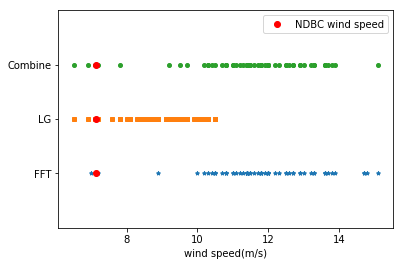

In [113]:
plt.plot(np.ravel(speed[0]), np.ones(len(np.ravel(speed[0]))),'*',markersize=4)
plt.plot(np.ravel(speed[1]), np.ones(len(np.ravel(speed[1])))*1.5,'s',markersize=4)
plt.plot(np.ravel(speed1), np.ones(len(np.ravel(speed1)))*2,'o',markersize=4)
plt.ylim(0.5,2.5)
plt.yticks((1,1.5,2),('FFT','LG','Combine'))
plt.plot(ndbc_speed,1,'ro',label='NDBC wind speed')
plt.plot(ndbc_speed,1.5,'ro')
plt.plot(ndbc_speed,2,'ro')
plt.legend()
plt.xlabel('wind speed(m/s)')
plt.savefig('1_speed_result.eps')

In [49]:
x = np.reshape(x,(30,40))

In [50]:
for i in range(5, 30-5, 10):
    for j in range(5, 40-5, 10):
        x[i,j]=0

In [51]:
x_, y_ = np.arange(5, 30-5, 10), np.arange(5, 40-5, 10)
p1 = np.meshgrid(x_, y_)

In [52]:
x[p1]

array([[0, 0],
       [0, 0],
       [0, 0]])

In [54]:
print(x)

[[   0    1    2 ...,   37   38   39]
 [  40   41   42 ...,   77   78   79]
 [  80   81   82 ...,  117  118  119]
 ..., 
 [1080 1081 1082 ..., 1117 1118 1119]
 [1120 1121 1122 ..., 1157 1158 1159]
 [1160 1161 1162 ..., 1197 1198 1199]]


第二幅图


In [28]:
data = Dataset('./S1A_IW_GRDH_1SDV_20170518T233538_20170518T233603_016643_01B9E6_D58F.nc')
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
sigma_vv = data.variables['Sigma0_VV'][:]
sigma_vh = data.variables['Sigma0_VH'][:]
incident = data.variables['incident_angle'][:]

In [29]:

ndbc_dire = (350-97+90)%360
sub_lat = lat[11400:14100,7150:10450]
sub_lon = lon[11400:14100,7150:10450]
poly_lat = [sub_lat[0,0],sub_lat[0, -1],sub_lat[-1,-1],sub_lat[-1, 0],sub_lat[0,0]]
poly_lon =  [sub_lon[0,0],sub_lon[0, -1],sub_lon[-1,-1],sub_lon[-1, 0],sub_lon[0,0]]
sub_vv = sigma_vv[11400:14100,7150:10450]
sub_vh = sigma_vh[11400:14100,7150:10450]
sub_in = incident[11400:14100,7150:10450]
#风向
sub_size=400
dire_ = direction.get_dir(sub_vv, sub_size=sub_size, remove_ambi = True, ndbc_= ndbc_dire)


sub_size_h = int(sub_size/2)
shape_x = sub_vv.shape[0]
shape_y = sub_vv.shape[1]
x_, y_ = np.arange(sub_size_h, shape_x-sub_size_h, sub_size), np.arange(sub_size_h, shape_y-sub_size_h, sub_size)
points = np.meshgrid(x_, y_)


image1 = Image.fromarray(sub_vv)
out1 = image1.transpose(Image.FLIP_LEFT_RIGHT)
out1 = out1.rotate(10.5, expand=1)
sub= np.array(out1)
#map对象
map_1 = Basemap(projection='stere',lat_0=np.max(sub_lat),lon_0=np.min(sub_lon),\
            llcrnrlat=np.min(sub_lat) ,urcrnrlat=np.max(sub_lat),\
            llcrnrlon=np.min(sub_lon),urcrnrlon=np.max(sub_lon), resolution='f')

X, Y = map_1(sub_lon[points], sub_lat[points])
index = 0
color_list = [(1, 1, 1), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (1, 0, 1), (0, 1, 1)]




In [30]:
ndbc_speed = 9.3*np.power(10/5,0.11)
speed1 = []
for d in dire_:
    speed1.append(get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, d[points],c= 'cmod5n'))
ndbc_dire = (190-318+90)%360
ww1 = direction.Median_filter(w1=dire_[0][points], w2=dire_[1][points], b=ndbc_dire, filter_size=4)
speed11 = get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, ww1,c='cmod5n')

In [31]:
speed2 = []
for d in dire_:
    speed2.append(get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, d[points], c='horstmann'))
ww2 = direction.Median_filter(w1=dire_[0][points], w2=dire_[1][points], b=ndbc_dire, filter_size=4)
speed21 = get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, ww2,c='horstmann')

In [32]:
speed3 = []
for d in dire_:
    speed3.append(get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, d[points], c='combine'))
ww3 = direction.Median_filter(w1=dire_[0][points], w2=dire_[1][points], b=ndbc_dire, filter_size=4)
speed31 = get_speed(sub_vv, 10*np.log10(sub_vh), sub_in, sub_size, ww3,c='combine')

/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is d

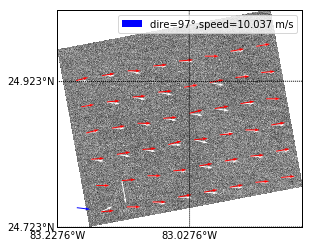

In [144]:
map_1.drawcoastlines()
map_1.imshow(-10*np.log10(sub),origin='upper',cmap='gray')
parallels=np.arange(np.min(sub_lat), np.max(sub_lat), 0.2)
map_1.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(sub_lon), np.max(sub_lon), 0.2)
map_1.drawmeridians(meridians,labels=[0,0,0,1])
map_1.drawmapboundary(fill_color='white')
index=0
for d, s in zip(dire_, speed1):
    U1 = 10*s*np.sin((80-d[points])%360/180*np.pi)
    V1 = 10*s*np.cos((80-d[points])%360/180*np.pi)
    map_1.quiver(X, Y, U1, V1, width=0.004, color=color_list[index])
    index+=1
map_1.quiver([[3000]], [3000], [[10*ndbc_speed*np.sin(97/180*np.pi)]], [[10*ndbc_speed*np.cos(97/180*np.pi)]], width=0.004, color=(0,0, 1), label='dire=97°,speed=%.3f m/s'%ndbc_speed)
plt.legend()
plt.savefig('./2_filed_4.png', dpi=400)

In [134]:
ndbc_dire

343

/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/yangchao/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecationWarning: axes.hold is d

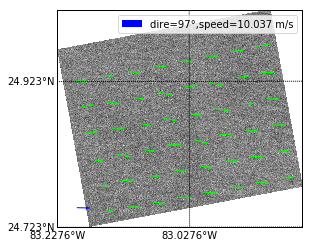

In [145]:
d = ww1
U1 = 10*speed1*np.sin((80-d)%360/180*np.pi)
V1 = 10*speed1*np.cos((80-d)%360/180*np.pi)

map_1.drawcoastlines()
map_1.imshow(-10*np.log10(sub),origin='upper',cmap='gray')
parallels=np.arange(np.min(sub_lat), np.max(sub_lat), 0.2)
map_1.drawparallels(parallels,labels=[1,0,0,0])
meridians = np.arange(np.min(sub_lon), np.max(sub_lon), 0.2)
map_1.drawmeridians(meridians,labels=[0,0,0,1])
map_1.drawmapboundary(fill_color='white')

map_1.quiver(X, Y, U1, V1, width=0.004, color=(0, 1, 0))
map_1.quiver([[3000]], [3000], [[10*ndbc_speed*np.sin(97/180*np.pi)]], [[20*np.cos(97/180*np.pi)]], width=0.004, color=(0,0, 1), label='dire=97°,speed=%.3f m/s'%ndbc_speed)
plt.legend()
plt.savefig('./2_filed_m_4.png', dpi=400)

In [33]:
print(np.sqrt(np.sum(np.power(ndbc_speed-speed1[0],2))/len(np.ravel(speed1[0]))))
print(np.sqrt(np.sum(np.power(speed1[0]-np.mean(speed1[0]),2))/len(np.ravel(speed1[0]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed1[1],2))/len(np.ravel(speed1[1]))))
print(np.sqrt(np.sum(np.power(speed1[1]-np.mean(speed1[1]),2))/len(np.ravel(speed1[1]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed11,2))/len(np.ravel(speed11))))
print(np.sqrt(np.sum(np.power(speed11-np.mean(speed11),2))/len(np.ravel(speed11))))

1.39427833788
1.09007171471
1.20324214819
0.298742965055
1.07692601907
0.325976243935


In [34]:

print(np.sqrt(np.sum(np.power(ndbc_speed-speed2[0],2))/len(np.ravel(speed2[0]))))
print(np.sqrt(np.sum(np.power(speed2[0]-np.mean(speed2[0]),2))/len(np.ravel(speed2[0]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed2[1],2))/len(np.ravel(speed2[1]))))
print(np.sqrt(np.sum(np.power(speed2[1]-np.mean(speed2[1]),2))/len(np.ravel(speed2[1]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed21,2))/len(np.ravel(speed21))))
print(np.sqrt(np.sum(np.power(speed21-np.mean(speed21),2))/len(np.ravel(speed21))))

2.47904934097
0.988839792981
2.47904934097
0.988839792981
2.47904934097
0.988839792981


In [35]:
print(np.sqrt(np.sum(np.power(ndbc_speed-speed3[0],2))/len(np.ravel(speed3[0]))))
print(np.sqrt(np.sum(np.power(speed3[0]-np.mean(speed3[0]),2))/len(np.ravel(speed3[0]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed3[1],2))/len(np.ravel(speed3[1]))))
print(np.sqrt(np.sum(np.power(speed3[1]-np.mean(speed3[1]),2))/len(np.ravel(speed3[1]))))
print(np.sqrt(np.sum(np.power(ndbc_speed-speed31,2))/len(np.ravel(speed31))))
print(np.sqrt(np.sum(np.power(speed31-np.mean(speed31),2))/len(np.ravel(speed31))))

1.18889420711
0.983437053146
0.993914459127
0.258392130406
0.866562711548
0.303108891325


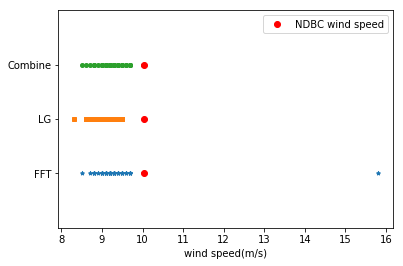

In [137]:
plt.plot(np.ravel(speed[0]), np.ones(len(np.ravel(speed[0]))),'*',markersize=4)
plt.plot(np.ravel(speed[1]), np.ones(len(np.ravel(speed[1])))*1.5,'s',markersize=4)
plt.plot(np.ravel(speed1), np.ones(len(np.ravel(speed1)))*2,'o',markersize=4)
plt.ylim(0.5,2.5)
plt.yticks((1,1.5,2),('FFT','LG','Combine'))
plt.plot(ndbc_speed,1,'ro',label='NDBC wind speed')
plt.plot(ndbc_speed,1.5,'ro')
plt.plot(ndbc_speed,2,'ro')
plt.legend()
plt.xlabel('wind speed(m/s)')
plt.savefig('2_speed_result.eps')